In [1]:
pip install datasets

In [2]:
from datasets import load_dataset

In [3]:
data= load_dataset("billsum", split="ca_test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
data=data.shuffle(seed=42).select(range(200))

In [5]:
data=data.train_test_split(test_size=0.2)

In [6]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [7]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 160
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 40
    })
})

(array([ 3.,  3.,  2.,  3.,  6.,  4.,  7.,  9., 13., 11.,  7.,  8.,  4.,
         4., 13.,  7.,  2.,  7.,  4.,  6.,  5.,  7.,  3.,  2.,  4.,  1.,
         4.,  1.,  2.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 219.  ,  351.78,  484.56,  617.34,  750.12,  882.9 , 1015.68,
        1148.46, 1281.24, 1414.02, 1546.8 , 1679.58, 1812.36, 1945.14,
        2077.92, 2210.7 , 2343.48, 2476.26, 2609.04, 2741.82, 2874.6 ,
        3007.38, 3140.16, 3272.94, 3405.72, 3538.5 , 3671.28, 3804.06,
        3936.84, 4069.62, 4202.4 , 4335.18, 4467.96, 4600.74, 4733.52,
        4866.3 , 4999.08, 5131.86, 5264.64, 5397.42, 5530.2 , 5662.98,
        5795.76, 5928.54, 6061.32, 6194.1 , 6326.88, 6459.66, 6592.44,
        6725.22, 6858.  ]),
 <BarContainer object of 50 artists>)

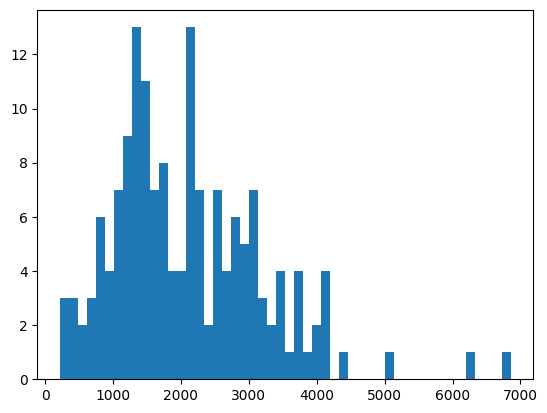

In [8]:
import matplotlib.pyplot as plt
train=data["train"]
input_lens=[len(tr['summary']) for tr in train]
plt.hist(input_lens,bins=50)

In [9]:
def tokenization(batch):
  inputs=["summarize: "+ x for x in batch['text']]
  tokenized_inputs = tokenizer(inputs, max_length=4000, truncation=True)
  labels = tokenizer(text_target=batch['summary'], max_length=1500, truncation=True)
  tokenized_inputs["labels"] = labels["input_ids"]
  return tokenized_inputs

In [10]:
tokenized_data=data.map(tokenization,batched=True)

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [11]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 160
    })
    test: Dataset({
        features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 40
    })
})

In [12]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [13]:
pip install rouge_score

In [14]:
pip install evaluate

In [15]:
import evaluate

rouge = evaluate.load("rouge")

In [16]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [17]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [21]:
training_args = Seq2SeqTrainingArguments(
    output_dir="summarizer",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    num_train_epochs=50,
    predict_with_generate=True,
    fp16=True,

)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

In [21]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [54]:
import gc
torch.cuda.empty_cache()
gc.collect()

261

In [ ]:
import os
os.kill(os.getpid(), 9)